In [2]:
#| echo: false
#| include: false


#Load Package
# ================
# Basic Utilities
# ================
import os
import pandas as pd
from pathlib import Path
import numpy as np

# ================
# Geospatial Data
# ================
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.ops import unary_union

# ================
# Raster Handling
# ================
import rasterio
from rasterio.plot import show
from rasterio.mask import mask 
from rasterio import features
from rasterio.sample import sample_gen

# ================
# Visualization
# ================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import contextily as ctx

# ================
# Machine Learning
# ================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# ================
# Spatial Analysis Utils
# ================
from scipy.ndimage import distance_transform_edt


data_dir = Path("data")
os.listdir(data_dir)


['.ipynb_checkpoints',
 'difference_map.tif',
 'dist_road.tif',
 'dist_village.tif',
 'dist_water.tif',
 'EFCOM_approx.cpg',
 'EFCOM_approx.dbf',
 'EFCOM_approx.prj',
 'EFCOM_approx.shp',
 'EFCOM_approx.shx',
 'gadm41_THA_0.cpg',
 'gadm41_THA_0.dbf',
 'gadm41_THA_0.prj',
 'gadm41_THA_0.shp',
 'gadm41_THA_0.shx',
 'LandCover_EFCOM_to_NDVI.tif',
 'major_roads.geojson',
 'NDVI_EFCOM_32647.tif',
 'NDVI_EFCOM_4326.tif',
 'NDVI_Thailand_2024_fixed.tif',
 'occurrence.geojson',
 'studyregion.geojson',
 'suitability_human.tif',
 'suitability_natural.tif',
 'village_polygon.geojson',
 'water_efcom.geojson',
 'WorldCover_EFCOM_2021.tif']

In [3]:
#| echo: false
#| include: false


#Check CRS

study_region_path = Path(data_dir) / "studyregion.geojson"
if study_region_path.exists():
    region = gpd.read_file(study_region_path)
else:
    region = gpd.read_file(Path(data_dir) / "EFCOM_approx.shp")

print("Study region CRS:", region.crs)

roads = gpd.read_file(Path(data_dir) / "major_roads.geojson")
villages = gpd.read_file(Path(data_dir) / "village_polygon.geojson")
water = gpd.read_file(Path(data_dir) / "water_efcom.geojson")
occ = gpd.read_file(Path(data_dir) / "occurrence.geojson")

print("Roads CRS:", roads.crs)
print("Villages CRS:", villages.crs)
print("Water CRS:", water.crs)
print("Occurrence CRS:", occ.crs)


Study region CRS: EPSG:4326


C:\Users\m1870\.conda\envs\musa\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 25830291 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
C:\Users\m1870\.conda\envs\musa\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 477127100 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


Roads CRS: EPSG:4326
Villages CRS: EPSG:4326
Water CRS: EPSG:4326
Occurrence CRS: EPSG:4326


In [4]:
#| echo: false
#| include: false

#Trim Elephant Data To Study Region

region_union = region.unary_union
occ_in_region = occ[occ.within(region_union)].copy()

print("All elephant points:", len(occ))
print("Elephant points inside region:", len(occ_in_region))


All elephant points: 577
Elephant points inside region: 260


C:\Users\m1870\AppData\Local\Temp\ipykernel_12532\857401672.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  region_union = region.unary_union


## Elephants & Study Area

### Asian Elephants: Why This Species Matters

Asian elephants (*Elephas maximus*) are an Endangered species and one of the last remaining large herbivores in Southeast Asia. Over the past century, their populations have declined sharply due to habitat loss, poaching, agricultural expansion, and increasing human–elephant conflict. These conflicts often arise when elephants leave protected forests in search of food, entering plantations or villages. The result is a complex landscape where conservation goals intersect directly with agricultural livelihoods and community safety.

Understanding **where elephants prefer to live** and **how human activities reshape their available habitat** is therefore essential for designing conservation strategies, anticipating risk, and reducing conflict.

### Study Region

Thailand hosts roughly 4,000 wild elephants, and nearly half live in five major forest regions. Among them, the **Eastern Forest Complex (EFCOM)** is one of the largest and most ecologically significant. It also experiences some of the **highest human–elephant conflict rates** in the country, due to expanding plantations, road networks, and scattered settlements around its edges.

The elephants in EFCOM rely on a mosaic of evergreen forest, mixed forest, grassland, and water bodies within protected areas. However, the landscape around these forests is rapidly changing—rubber, palm, and fruit plantations form a patchwork around the protected core, creating narrow ecological corridors and limiting elephant movement.

The map below shows the geographic scope of this project—a section of the Eastern Forest Complex that includes protected forest, agricultural land, villages, water bodies, and transportation infrastructure. This spatial context is important for interpreting both elephant occurrence patterns and model results later in the analysis.


![Image Reference: Chaiyarat, R.; Wettasin, M.; Youngpoy, N.; Cheachean, N. Use of Human Dominated Landscape as Connectivity Corridors among Fragmented Habitats for Wild Asian Elephants (Elephas maximus) in the Eastern Part of Thailand. Diversity 2023, 15, 6. https://doi.org/10.3390/d15010006](EFCOM.png)

![Study Region Boundary](map.html)

In [5]:
#| echo: false
#| include: false


ndvi_path = Path(data_dir) / "NDVI_Thailand_2024_fixed.tif"
ndvi_src = rasterio.open(ndvi_path)

print("NDVI CRS:", ndvi_src.crs)
print("NDVI bounds:", ndvi_src.bounds)
print("NDVI resolution:", ndvi_src.transform.a, ndvi_src.transform.e)

ndvi = ndvi_src.read(1)
ndvi = ndvi.astype("float32")
ndvi[ndvi <= -9999] = np.nan  

print("NDVI min/max (ignoring NaN):", np.nanmin(ndvi), np.nanmax(ndvi))


NDVI CRS: PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NDVI bounds: BoundingBox(left=704880.0, bottom=1343880.0, right=878400.0, top=1638090.0)
NDVI resolution: 30.0 -30.0
NDVI min/max (ignoring NaN): -0.38841534 0.71352226


In [6]:
#| echo: false
#| include: false


region_ndvi = region.to_crs(ndvi_src.crs)
geoms = [geom for geom in region_ndvi.geometry]

ndvi_clip, ndvi_clip_transform = mask(ndvi_src, geoms, crop=True)
ndvi_clip = ndvi_clip[0] 

print("Clipped NDVI shape:", ndvi_clip.shape)
print("Clipped NDVI min/max:", ndvi_clip.min(), ndvi_clip.max())


Clipped NDVI shape: (8924, 5435)
Clipped NDVI min/max: -0.36105967 0.71352226


In [7]:
#| echo: false
#| include: false

# 先确保大象点的 CRS 和 NDVI 一致（NDVI 是 4326）
occ_ndvi = occ_in_region.to_crs(ndvi_src.crs)

# 提取点坐标
coords = [(x,y) for x, y in zip(occ_ndvi.geometry.x, occ_ndvi.geometry.y)]

# 在 NDVI 栅格上采样
ndvi_at_elephants = list(ndvi_src.sample(coords))
ndvi_at_elephants = np.array(ndvi_at_elephants).flatten().astype("float32")

# 去掉可能的 NaN（落在 NoData 区域的点）
ndvi_at_elephants = ndvi_at_elephants[~np.isnan(ndvi_at_elephants)]

print("Elephant NDVI count:", len(ndvi_at_elephants))
print("Elephant NDVI min/max:", ndvi_at_elephants.min(), ndvi_at_elephants.max())
print("Elephant NDVI mean:", ndvi_at_elephants.mean())


Elephant NDVI count: 260
Elephant NDVI min/max: 0.02474089 0.59356636
Elephant NDVI mean: 0.4537316


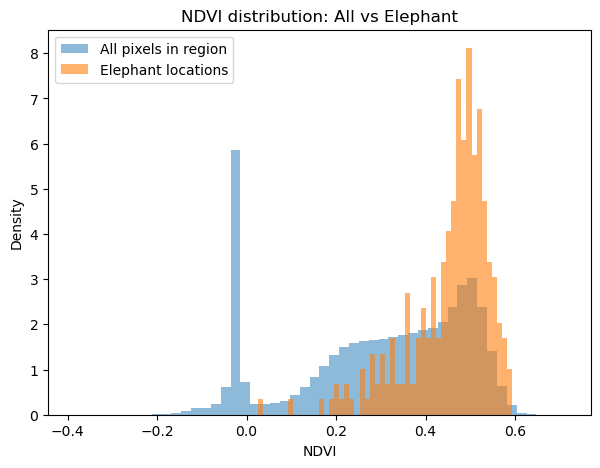

In [8]:
#| echo: false
#| include: false


# 全区域 NDVI 展平 & 去 NaN
ndvi_all = ndvi.flatten()
ndvi_all = ndvi_all[~np.isnan(ndvi_all)]

plt.figure(figsize=(7,5))

plt.hist(ndvi_all, bins=50, alpha=0.5, density=True, label="All pixels in region")
plt.hist(ndvi_at_elephants, bins=50, alpha=0.6, density=True, label="Elephant locations")

plt.xlabel("NDVI")
plt.ylabel("Density")
plt.title("NDVI distribution: All vs Elephant")
plt.legend()
plt.show()



In [9]:
#| echo: false
#| include: false

lc_path = data_dir / "WorldCover_EFCOM_2021.tif"
lc_src = rasterio.open(lc_path)

print("LandCover CRS:", lc_src.crs)
print("LandCover bounds:", lc_src.bounds)
print("LandCover resolution:", lc_src.transform.a, lc_src.transform.e)

lc = lc_src.read(1)
print("Unique landcover classes in full raster:", np.unique(lc))


LandCover CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
LandCover bounds: BoundingBox(left=100.99983318176811, bottom=12.29973287016449, right=102.60009202889863, top=14.700121140860263)
LandCover resolution: 0.00026949458523585647 -0.00026949458523585647
Unique landcover classes in full raster: [ 0 10 20 30 40 50 60 80 90 95]


In [10]:
#| echo: false
#| include: false


region_lc = region.to_crs(lc_src.crs)
geoms_lc = [geom for geom in region_lc.geometry]

lc_clip, lc_clip_transform = rasterio.mask.mask(lc_src, geoms_lc, crop=True)
lc_clip = lc_clip[0]

print("Clipped LC shape:", lc_clip.shape)
print("Unique classes in clipped LC:", np.unique(lc_clip))


Clipped LC shape: (8907, 5938)
Unique classes in clipped LC: [ 0 10 20 30 40 50 60 80 90 95]
